In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

## Load training and testing data

In [2]:
file = open('train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X_train = X.astype(np.float)
y_train = y.astype(np.float)
file.close()
print('#Training Data and #Featrues: %d %d' % X_train.shape)

#Training Data and #Featrues: 738 2


In [3]:
file = open('test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X_test = X.astype(np.float)
y_test = y.astype(np.float)
file.close()
print('#Testing Data and #Featrues: %d %d' % X_test.shape)

#Testing Data and #Featrues: 185 2


有了 data 以後，接下來我會利用 K-fold CV 來進行 models 的實驗。    

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

## KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

[3-NN]
    Validation accuracy = 0.8377


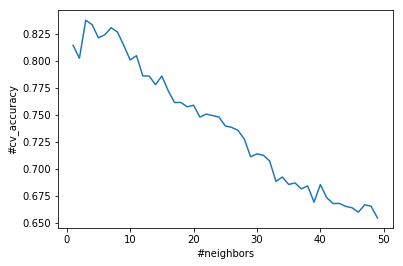

In [6]:
best_k, best_accuracy = -1, -1
clfs = {}
accuracy = []
best_scores = []
for k in range(1, 50, 1):  # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()],
                     ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=10)
    accuracy.append(scores.mean())
    if scores.mean() > best_accuracy:
        best_k, best_accuracy = k, scores.mean()
        best_scores = scores
    clfs[k] = pipe
print('[%d-NN]\n    Validation accuracy = %.4f' % (best_k, best_accuracy))
plt.plot(range(1, 50, 1), accuracy)
plt.xlabel('#neighbors')
plt.ylabel('#cv_accuracy')
plt.show()

In [7]:
y_pred = clfs[best_k].predict(X_test)

print('[%d-NN]' % best_k)
print('Accueacy: %.4f' % accuracy_score(y_test, y_pred))

[3-NN]
Accueacy: 0.7892


## Bagging

### Bagging + KNN

In [8]:
from sklearn.ensemble import BaggingClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=3)

pipe = Pipeline([['sc', StandardScaler()],
                 ['bag', BaggingClassifier(base_estimator=knn,
                                           n_estimators=500,
                                           max_samples=0.8,
                                           bootstrap=True,
                                           max_features=1.0,
                                           bootstrap_features=False,
                                           n_jobs=1,
                                           random_state=1)]])
pipe.fit(X_train, y_train)
# K-Fold CV
scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('[Bagginh + KNN]\n    Validation accuracy = %.4f' % scores.mean())

y_pred = pipe.predict(X_test)
print('    Testing Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Bagginh + KNN]
    Validation accuracy = 0.8470
    Testing Accuracy: 0.7892


### Bagging + Decision Tree

In [10]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
pipe = Pipeline([['sc', StandardScaler()],
                 ['bag', BaggingClassifier(base_estimator=tree,
                                           n_estimators=500,
                                           max_samples=0.8,
                                           bootstrap=True,
                                           max_features=1.0,
                                           bootstrap_features=False,
                                           n_jobs=1,
                                           random_state=1)]])
pipe.fit(X_train, y_train)
# K-Fold CV
scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('[Bagging + Decision Tree]\n    Validation accuracy = %.4f' % scores.mean())

y_pred = pipe.predict(X_test)
print('    Testing Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Bagging + Decision Tree]
    Validation accuracy = 0.8265
    Testing Accuracy: 0.8162


## Adaboost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

### Adaboost + Decision Tree

In [12]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)

pipe = Pipeline([['sc', StandardScaler()],
                 ['ada', AdaBoostClassifier(base_estimator=tree, n_estimators=1000)]])
pipe.fit(X_train, y_train)
# K-Fold CV
scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('[Adaboost + KNN]\n    Validation accuracy = %.4f' % scores.mean())

y_pred = pipe.predict(X_test)
print('    Testing Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Adaboost + KNN]
    Validation accuracy = 0.7767
    Testing Accuracy: 0.7676


## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
pipe = Pipeline([['sc', StandardScaler()],
                 ['forest', RandomForestClassifier(criterion='entropy',
                                                   n_estimators=200, 
                                                   random_state=1,
                                                   n_jobs=2)]])
pipe.fit(X_train, y_train)
scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('[Random Forest]\n    Validation accuracy = %.4f' % scores.mean())
y_pred = pipe.predict(X_test)
print('    Testing Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Random Forest]
    Validation accuracy = 0.8346
    Testing Accuracy: 0.8054


根據實驗可以發現，Bagging 配合 Decision Tree 的表現最好。